# Olympic Medal Prediction - Visualisation and Feature Ranking

## 1. Setup and Load Results

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

try:
    with open('evaluation_results.pkl', 'rb') as f:
        results = pickle.load(f)

    y_test = results['y_test']
    y_test_pred = results['y_test_pred']
    y_test_pred_proba = results['y_test_pred_proba']
    feature_importance_df = results['feature_importance_df']
    best_model = results['best_model']
    grid_search = results['grid_search']
    
    df_features = pd.read_pickle('olympic_data_processed.pkl')
    
    print("Results loaded successfully!")
    print(f"Test set size: {len(y_test)}")
    print(f"Features analysed: {len(feature_importance_df)}")
    
except FileNotFoundError:
    print("Please run the model development notebook first.")
    raise

Results loaded successfully!
Test set size: 4280
Features analyzed: 16


## 2. Model Performance Visualisation

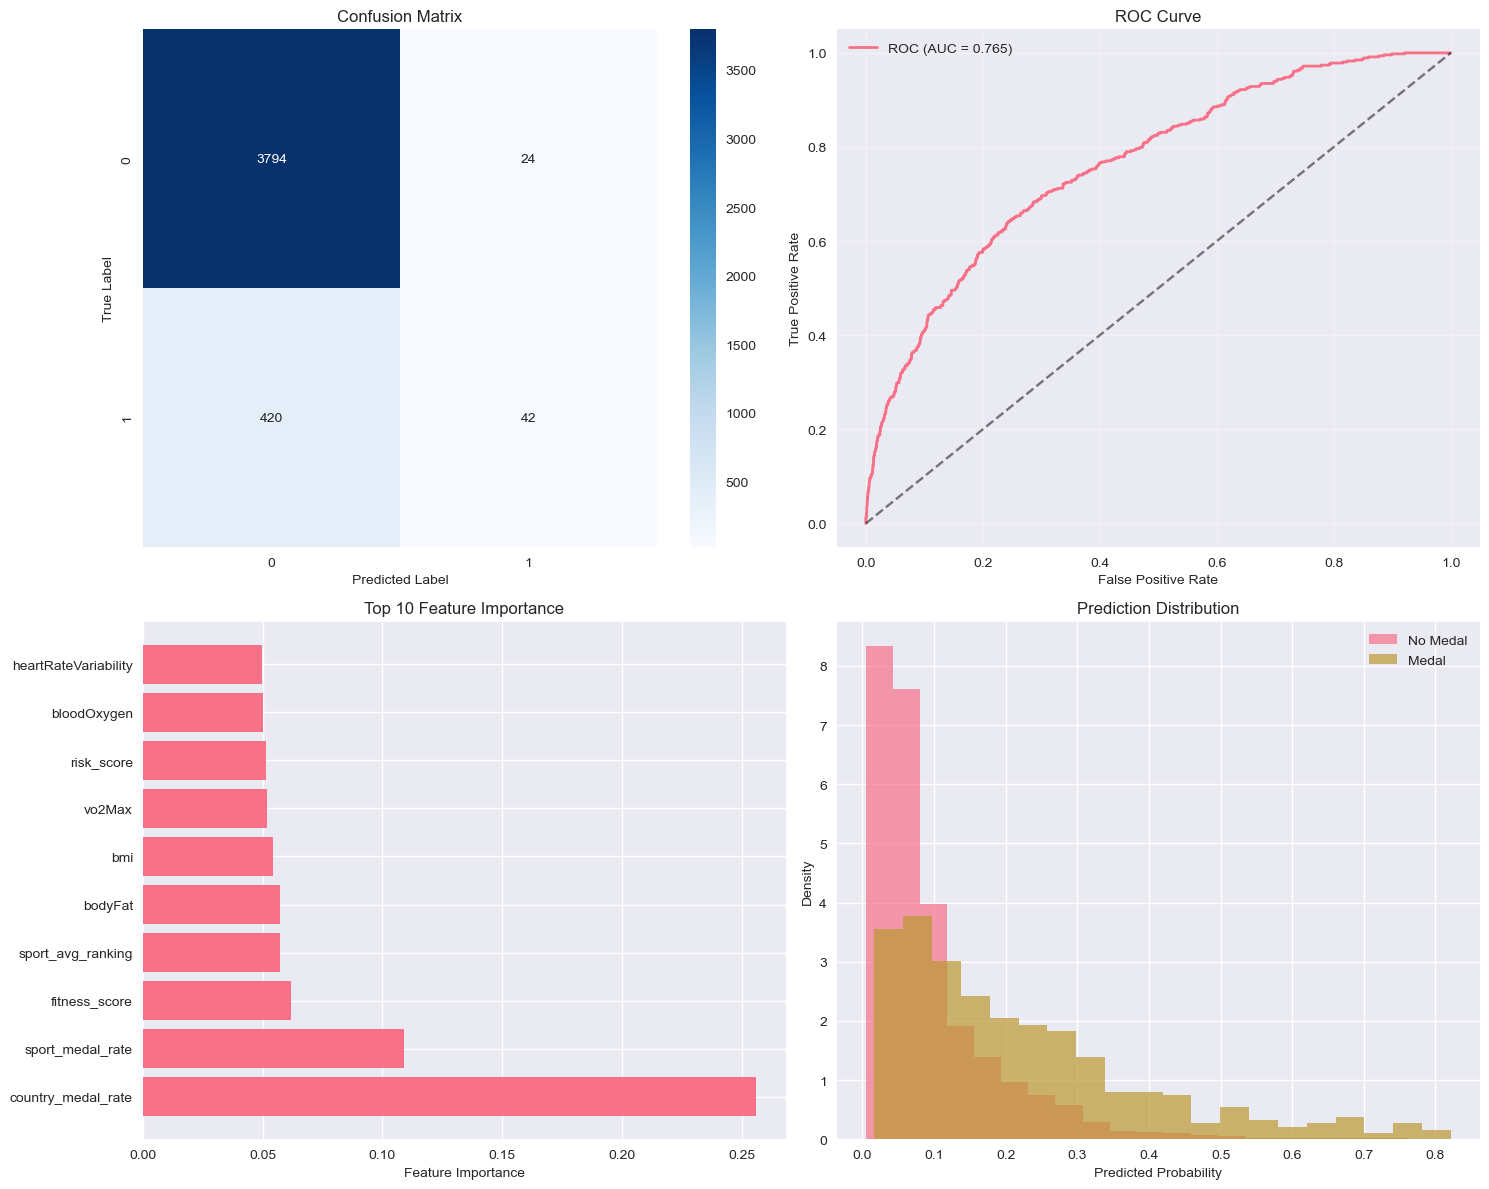

Model Performance Summary:
   AUC-ROC:  0.7646
   Accuracy: 0.8963
   F1-Score: 0.1591


In [5]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {test_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

top_features = feature_importance_df.head(10)
axes[1, 0].barh(range(len(top_features)), top_features['importance'])
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['feature'])
axes[1, 0].set_xlabel('Feature Importance')
axes[1, 0].set_title('Top 10 Feature Importance')

axes[1, 1].hist(y_test_pred_proba[y_test == 0], bins=20, alpha=0.7, label='No Medal', density=True)
axes[1, 1].hist(y_test_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Medal', density=True)
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Prediction Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"Model Performance Summary:")
print(f"   AUC-ROC:  {test_auc:.4f}")
print(f"   Accuracy: {test_accuracy:.4f}")
print(f"   F1-Score: {test_f1:.4f}")

## 3. Detailed Feature Importance Analysis

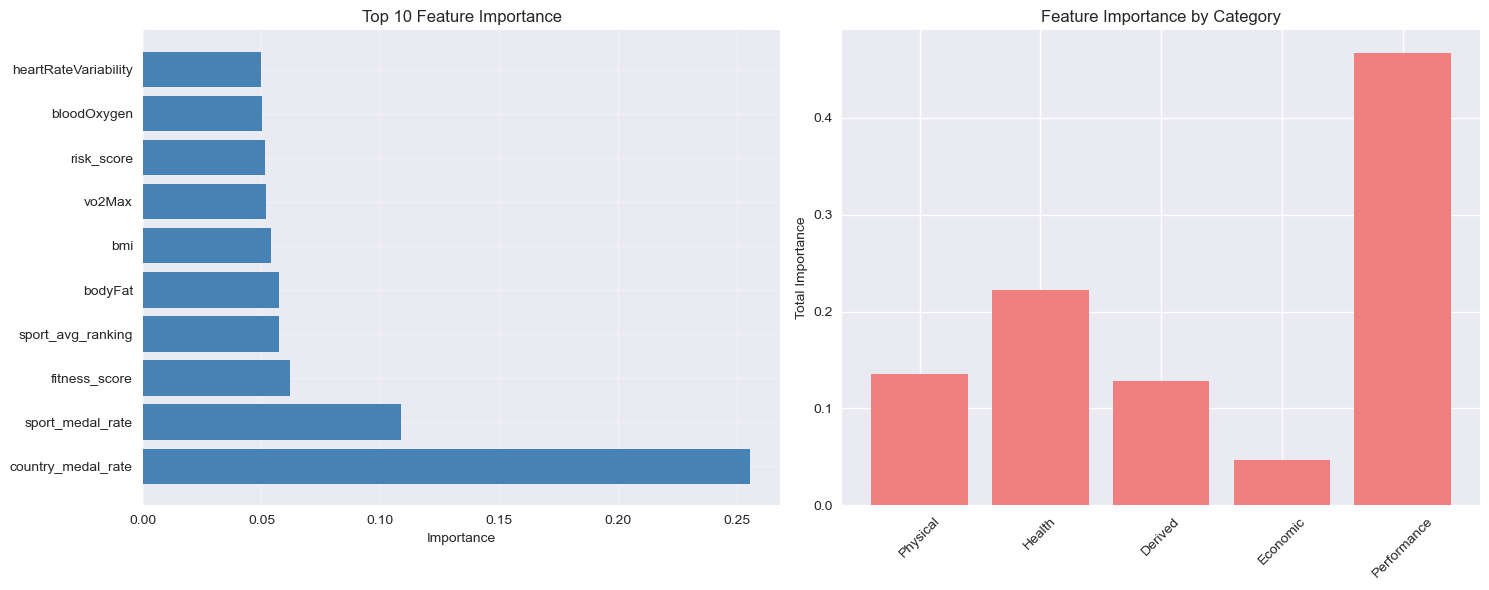


10 most important features:
---------------------------------------------
 1. country_medal_rate       : 0.2557
 2. sport_medal_rate         : 0.1088
 3. fitness_score            : 0.0619
 4. sport_avg_ranking        : 0.0573
 5. bodyFat                  : 0.0572
 6. bmi                      : 0.0542
 7. vo2Max                   : 0.0520
 8. risk_score               : 0.0513
 9. bloodOxygen              : 0.0503
10. heartRateVariability     : 0.0496


In [6]:
feature_categories = {
    'Physical': ['height', 'weight', 'bmi'],
    'Health': ['bodyFat', 'heartRateVariability', 'vo2Max', 'bloodOxygen', 'injurySeverityScore'],
    'Derived': ['fitness_score', 'risk_score', 'estimated_age'],
    'Economic': ['gdp_per_capita'],
    'Performance': ['country_medal_rate', 'country_avg_ranking', 'sport_medal_rate', 'sport_avg_ranking']
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

top_features = feature_importance_df.head(10)
ax1.barh(range(len(top_features)), top_features['importance'], color='steelblue')
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'])
ax1.set_xlabel('Importance')
ax1.set_title('Top 10 Feature Importance')
ax1.grid(True, alpha=0.3)

category_data = []
for category, features in feature_categories.items():
    importance = feature_importance_df[
        feature_importance_df['feature'].isin(features)
    ]['importance'].sum()
    category_data.append((category, importance))

categories, importances = zip(*category_data)
ax2.bar(categories, importances, color='lightcoral')
ax2.set_ylabel('Total Importance')
ax2.set_title('Feature Importance by Category')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n10 most important features:")
print("-" * 45)
for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<25}: {row['importance']:.4f}")